http://www.ipeadata.gov.br/

https://dadosdadosdados.wordpress.com/2015/09/25/trabalhando-com-series-temporais-no-r-parte-i-2/

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

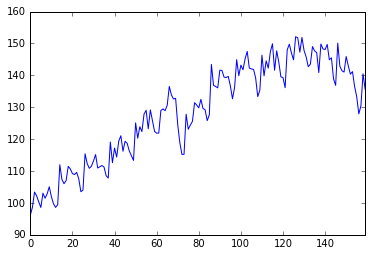

In [2]:
dataset = pd.read_csv('ibc_br_20160918.csv', usecols=[0,1], engine='python')
dataset.columns = ['DATA','IBC_BR']
dataset['IBC_BR'].plot()

In [3]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2, activity_l2

from sklearn.metrics import r2_score

Using Theano backend.


In [4]:
# fix random seed for reproducibility
numpy.random.seed(42)

In [5]:
# load the dataset
#dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataframe = pandas.read_csv('ibc_br_20160918.csv', usecols=[0,1], engine='python')
dataframe.columns = ['DATA','IBC_BR']
#dataset = dataframe['IBC_BR'].values.reshape(-1, 1)
#dataset = dataset.astype('float32')

### Add trend and seasonal factor

In [6]:
seasonal = pd.get_dummies(dataframe['DATA'].apply(lambda x: int(str(x).split('.')[-1])))
seasonal.columns = ['D'+str(x) for x in range(1,12)]

In [7]:
data = pd.concat([dataframe, seasonal], axis=1)
data['TREND'] = range(0, dataframe.shape[0])

In [8]:
data['LAG_IBC_BR'] = data.groupby(['DATA'])['IBC_BR'].mean().shift(1).reset_index(drop=True)

In [9]:
data = data.rename(columns={'IBC_BR':'TARGET'})

In [10]:
data = data.fillna(0)

In [11]:
del data['DATA']

In [12]:
data['perc_TARGET'] = data['TARGET']/data['LAG_IBC_BR']-1
data.ix[np.isinf(data['perc_TARGET']),'perc_TARGET'] = 0
target = data['TARGET']
del data['TARGET']

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(df, ratio=0.67):
    
    train_size = int(len(data) * ratio)
    test_size = len(data) - train_size
    train, test = data.loc[0:train_size,:], data.loc[train_size:len(data),:]
    
    trainX, trainY = [], []
    trainY = train['perc_TARGET']
    trainX = train.ix[:, train.columns != 'perc_TARGET']

    testX, testY = [], []
    testY = test['perc_TARGET']
    testX = test.ix[:, test.columns != 'perc_TARGET']
    
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    trainX = scaler.fit_transform(trainX)
    
#    trainX = scale(trainX)
    testX = scaler.transform(testX)
    

    return np.array(trainX), np.array(trainY), np.array(testX), np.array(testY)

In [14]:
trainX, trainY, testX, testY = create_dataset(data)

In [15]:
print(trainX.shape, testX.shape)

((108, 13), (53, 13))


In [16]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#trainX = numpy.reshape(trainX, (1, trainX.shape[0], trainX.shape[1]))
#testX = numpy.reshape(testX, (1, testX.shape[0], testX.shape[1]))

In [17]:
trainX.shape

(108, 1, 13)

In [18]:
# import numpy as np
# from keras import backend as K
# def mean_squared_error(y_true, y_pred):
#     return K.mean(K.square(y_true - y_pred), axis=-1)

# def rsquared(y_true, y_pred):
#     ssres = K.mean(K.square(y_true - y_pred), axis=-1)
#     sstot = K.square(y_true -K.mean(y_true))
#     rsquare = (1 - (ssres/sstot))
#     return rsquare

# def sum_squared_error(y_true, y_pred):
#     return K.sum(K.square(y_true - y_pred), axis=-1)

In [19]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_dim=(data.shape[1]-1),return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(12))
model.add(Dense(1, W_regularizer=l2(1e-6), activity_regularizer=activity_l2(1e-6)))
model.compile(loss='mean_squared_error', optimizer='rmsprop')

hist = model.fit(trainX, trainY, nb_epoch=60, batch_size=1, verbose=2, validation_split=0.3)

Train on 75 samples, validate on 33 samples
Epoch 1/60
0s - loss: 0.0016 - val_loss: 0.0011
Epoch 2/60
0s - loss: 0.0016 - val_loss: 0.0011
Epoch 3/60
0s - loss: 0.0016 - val_loss: 0.0011
Epoch 4/60
0s - loss: 0.0015 - val_loss: 0.0011
Epoch 5/60
0s - loss: 0.0016 - val_loss: 0.0011
Epoch 6/60
0s - loss: 0.0016 - val_loss: 0.0011
Epoch 7/60
0s - loss: 0.0015 - val_loss: 0.0011
Epoch 8/60
0s - loss: 0.0016 - val_loss: 0.0011
Epoch 9/60
0s - loss: 0.0015 - val_loss: 0.0011
Epoch 10/60
0s - loss: 0.0015 - val_loss: 0.0010
Epoch 11/60
0s - loss: 0.0015 - val_loss: 0.0011
Epoch 12/60
0s - loss: 0.0015 - val_loss: 0.0011
Epoch 13/60
0s - loss: 0.0015 - val_loss: 0.0010
Epoch 14/60
0s - loss: 0.0015 - val_loss: 0.0010
Epoch 15/60
0s - loss: 0.0015 - val_loss: 0.0010
Epoch 16/60
0s - loss: 0.0014 - val_loss: 9.8822e-04
Epoch 17/60
0s - loss: 0.0014 - val_loss: 0.0013
Epoch 18/60
0s - loss: 0.0015 - val_loss: 0.0010
Epoch 19/60
0s - loss: 0.0014 - val_loss: 0.0010
Epoch 20/60
0s - loss: 0.0014 

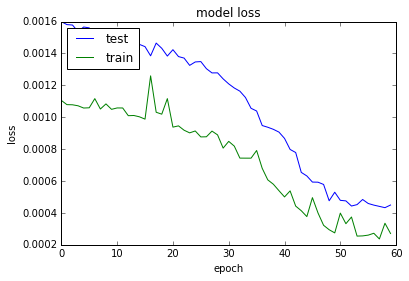

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')

In [21]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

/Users/sandorcaetano/anaconda/lib/python2.7/site-packages/keras/backend/theano_backend.py:503: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


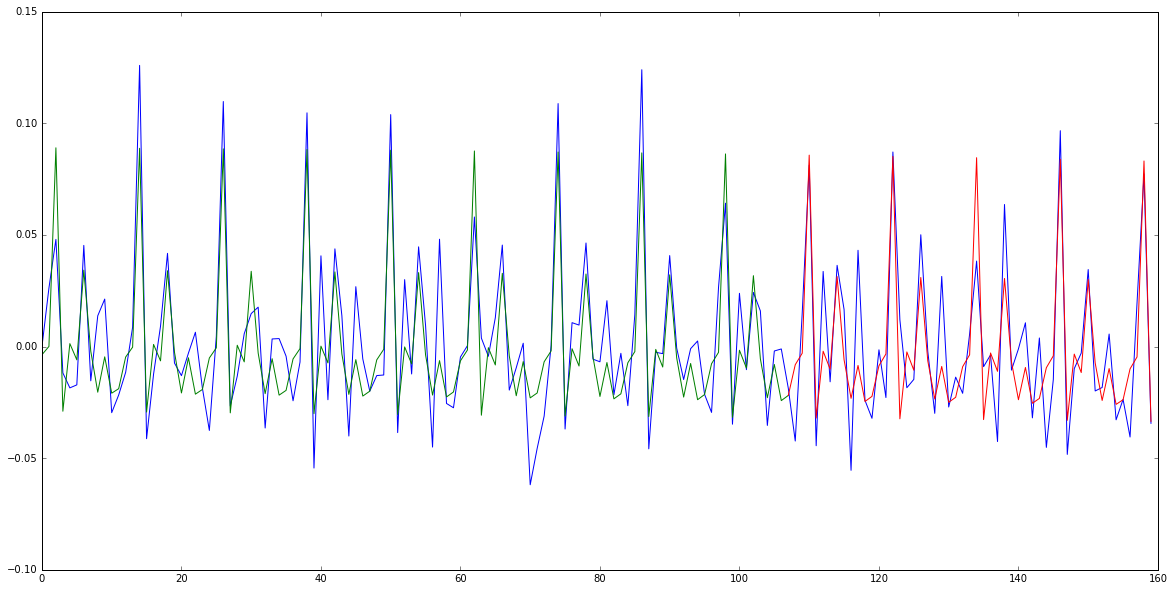

In [22]:
trainPredictPlot = np.zeros((data.shape[0],1))
trainPredictPlot[:,:] = np.nan
trainPredictPlot[0:len(trainPredict),:] = trainPredict

testPredictPlot = np.zeros((data.shape[0],1))
testPredictPlot[:,:] = np.nan
testPredictPlot[-len(testPredict):len(data),:] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(data['perc_TARGET'])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

In [23]:
plotTrain = (1+trainPredictPlot[:,0])*data['LAG_IBC_BR']
plotTest = (1+testPredictPlot[:,0])*data['LAG_IBC_BR']

(95, 160)

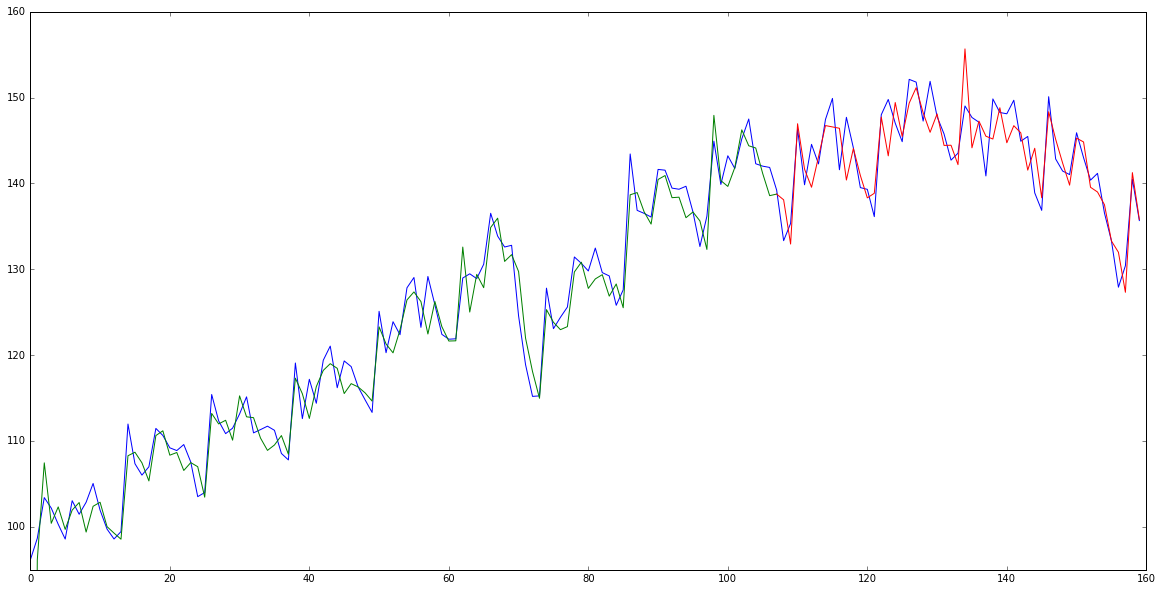

In [24]:
# plot baseline and predictions
plt.figure(figsize=(20,10))
#plt.plot(data['perc_TARGET'])
plt.plot(target)
plt.plot(plotTrain)
plt.plot(plotTest)
plt.ylim(95,160)

In [25]:
train_r2 = round(r2_score(target[1:len(trainPredict)], plotTrain[1:len(trainPredict)]),2)
test_r2 = round(r2_score(target[-len(testPredict):len(plotTest)],plotTest[-len(testPredict):len(plotTest)]),2)
print 'Train R2 - %s' % train_r2, ' / ','Test R2 - %s' % test_r2


Train R2 - 0.97  /  Test R2 - 0.72
